# Steps:

1. Clustering on cities through K-means;
2. GA on each cluster: obtain provinces (use normal total length);
3. GA for sorting custers: obtain candidate trace as concatenation of cluster routes (use normal total length);
4. SA on on obtained candidate trace, with special mutation and fitness func for primes.

# Imports

In [1]:
from datetime import datetime
import json
import numpy as np

In [2]:
cities = np.genfromtxt('cities.csv', delimiter=',', skip_header = 1)

# Clustering

In [3]:
from sklearn.cluster import KMeans

We partition the cities in 1000 clusters, using k-means.

In [4]:
n = 1000

We have run the following code and saved the clusters as a txt file, so we just import it now

In [5]:
# kmeans = KMeans(n_clusters=n, random_state=0)
# kmeans.fit(cities[:, 1:3])

In [6]:
clusters = np.genfromtxt('files/1000subsets.txt', skip_header = 0).astype(int)

In [7]:
clusters

array([894, 654, 614, ..., 263, 305,  80])

We add the information regarding the cluster to the cities array.

In [8]:
kcities = np.concatenate((cities, clusters[:, np.newaxis]), 1)

In [9]:
subs = [0]*n
for i in range(n):
    subs[i] = kcities[kcities[:, 3] == i][:, :3]

In [10]:
subs = np.array(subs)

In [11]:
lens = np.array([len(subs[i]) for i in range(n)])
lens[:50]

array([230, 118, 121, 168,  89, 163, 310, 288, 277, 156, 289, 228, 172,
       273, 151, 156, 261, 236, 190, 234, 183,  73, 242, 222, 228, 161,
       244, 282, 265, 198, 138, 288, 268, 181, 274, 158, 160, 203, 127,
       152, 216, 313, 222, 192, 218, 145, 241, 296, 151, 137])

In [12]:
sum(lens)

197769

# Running GA in each cluster

In [13]:
from ga import GA, route_fitness, shift_mutation, roulette_selection
from ga import two_point_crossover, total_length_loop, edp, not_prime

In [14]:
np.random.seed(4)
random_perm = np.random.permutation(len(cities))

In [15]:
total_length_loop(random_perm, cities)

442479971.65202415

In [16]:
a = [0]*n
b = [0]*n
c = [0]*n
d = [0]*n
e = [0]*n

In [17]:
for i in range(n):
    e[i] = np.arange(len(subs[i]))

We have created a list of lists, each consisting of the city ids in each cluster:

In [18]:
c_ids = [el[:,0] for el in subs]

In [19]:
start_routes = []
for i in range(n):
    start_routes.append(c_ids[i][e[i]])

In [20]:
start_route = np.concatenate(start_routes).astype(int)

In [21]:
all(np.isin(start_route, cities[:,0])) 

True

In [22]:
all(np.isin(cities[:,0], start_route))

True

In [23]:
total_length_loop(start_route, cities)

13139371.401815962

After running the following...

In [24]:
np.random.seed(4)
start = datetime.now()
startl = datetime.now()
p = 0 
initial_dist = total_length_loop(start_route, cities)
last_dist = initial_dist
print('Initial distance: {}'.format(last_dist))
for i in range(n):
    if i % 100 == 0:
        print('\nStart Loop {} at {}'.format(i, startl))
    a[i], b[i], c[i], d[i], e[i] = GA(subs[i], np.inf, 30, 10, route_fitness, [shift_mutation], 0.1,
                                      sel_fun=roulette_selection, cross_fun=two_point_crossover,
                                      max_no_change = 500, length_fun = total_length_loop)
    if (i % (99 + p) == 0) and i > 0:
        p += 100
        endl = datetime.now()
        print('End loop {} at {}: {} seconds'.format(i, endl, (endl-startl).total_seconds()))
        startl = datetime.now()
        temp_routes = []
        for j in range(n):
            temp_routes.append(c_ids[j][e[j]])
        temp_full_route = np.concatenate(temp_routes).astype(int)
        temp_tot = total_length_loop(temp_full_route, cities)
        print('Total distance so far: {}'.format(temp_tot))
        if all(np.isin(temp_full_route, cities[:,0])) and all(np.isin(cities[:,0], temp_full_route)):
            print("Checked: the path goes through all cities")
        print('Improvement: {}'.format(temp_tot - last_dist))
        print('Total Improvement: {}'.format(temp_tot - initial_dist))
        last_dist = temp_tot    
        
end = datetime.now()
print('\nTotal time: {}'.format((end-start).total_seconds()))

Initial distance: 13139371.401815962

Start Loop 0 at 2019-07-04 11:04:38.290970
End loop 99 at 2019-07-04 11:15:13.220641: 634.929671 seconds
Total distance so far: 12590740.842975082
Checked: the path goes through all cities
Improvement: -548630.5588408802
Total Improvement: -548630.5588408802

Start Loop 100 at 2019-07-04 11:15:13.220641
End loop 199 at 2019-07-04 11:25:13.561627: 600.340986 seconds
Total distance so far: 12053523.824350068
Checked: the path goes through all cities
Improvement: -537217.0186250135
Total Improvement: -1085847.5774658937

Start Loop 200 at 2019-07-04 11:25:13.561627
End loop 299 at 2019-07-04 11:36:09.129431: 655.567804 seconds
Total distance so far: 11516201.33771347
Checked: the path goes through all cities
Improvement: -537322.4866365977
Total Improvement: -1623170.0641024914

Start Loop 300 at 2019-07-04 11:36:09.129431
End loop 399 at 2019-07-04 11:45:31.342081: 562.21265 seconds
Total distance so far: 10967903.767421352
Checked: the path goes thr

Running the algorithm we have created a list 'e'. Each element e[i] in this list is the best route found by running GA on subs[i]. We now order each list c_ids[i] by e[i] in order to obtain the routes specified by their city ids. 

In [25]:
routes = []
for i in range(n):
    routes.append(c_ids[i][e[i]])

We can now concatenate these routes in order to find a route on the full set of cities.

In [26]:
full_route = np.concatenate(routes)

We order the route so that it starts and ends at 0.

In [27]:
zi = np.where(full_route == 0)[0][0]

In [28]:
full_route = np.concatenate((full_route[zi:], full_route[:zi]))

In [29]:
full_route = full_route.astype(int)

In [30]:
np.savetxt('files/full_route_GA_in_clusts.txt', full_route)

We load the saved file containing this route:

In [31]:
full_route = np.genfromtxt('files/full_route_GA_in_clusts.txt').astype(int)

As a check, we can see that the length of the full route is correct.

In [32]:
len(full_route)

197769

Also, every city in the path is the id of a city:

In [33]:
all(np.isin(full_route, cities[:,0])) 

True

... and every city is in the path:

In [34]:
all(np.isin(cities[:,0], full_route)) 

True

The total length through this route:

In [35]:
total_length_loop(full_route, cities)

7831973.175599158

Let us now see what would be the length of this route if we penalize every 10th step not starting from a prime city.

We create a masking list for non-prime number:

In [36]:
np_not_prime = np.vectorize(not_prime)
nums = np.arange(0, len(cities))
not_primes_bool = np_not_prime(nums)

We now use the list to find the total length, where we penalize each 10th step originating from a city that is not prime.

In [37]:
edp(full_route, cities, not_primes_bool)

7902785.316364356

#### Save subroutes as json

We also save the subroutes as a json file:

In [38]:
routes_dict = dict()
for i in range(len(routes)):
    routes_dict[i] = list(routes[i])

In [39]:
with open('files/subroutes_GA_in_clusts.json', 'w') as fp:
    json.dump(routes_dict, fp)

# Running GA to find order of subroutes

Reload routes:

In [40]:
with open('files/subroutes_GA_in_clusts.json', 'r') as fp:
    loaded_json = json.load(fp)

In [41]:
json_routes = [loaded_json[str(i)] for i in range(1000)]

In [42]:
full_json_route = np.concatenate(json_routes)
len(full_json_route)

197769

In [43]:
# delete 0 ecc
zij = np.where(full_json_route == 0)[0][0]
zij

179193

In [44]:
full_json_route = np.concatenate((full_json_route[zij:], full_json_route[:zij])) # reorder full route as if starting from 0 to 0, and delete 0s
len(full_json_route) # the 0 will be added during length computation

197769

In [45]:
edp(full_json_route.astype(int), cities, not_primes_bool)

7902785.316364356

In [46]:
routes = json_routes

We now apply GA for ordering the clusters:

In [47]:
for i in range(len(routes)):
    routes[i] = np.array(routes[i]).astype(int)

In [48]:
routes = np.array(routes)

After running the following ...

In [49]:
from ga import GA, subset_fitness, swap_mutation, reverse_mutation
from ga import two_point_crossover, total_length_loop, edp, not_prime

In [50]:
np.random.seed(4)
s1, s2, s3, s4, s5 = GA(cities, np.inf, 30, 10, subset_fitness, [shift_mutation], 0.1,
                        roulette_selection, cross_fun=two_point_crossover, max_no_change = 500,
                        length_fun = total_length_loop, on_subsets= True, subs = routes, verbose = True)

Iter 0, ItNoChange 0, Best 7761197.5345714465
Iter 1000, ItNoChange 3, Best 7236799.774131638
Iter 2000, ItNoChange 6, Best 7058641.832748582
Iter 3000, ItNoChange 0, Best 6952621.101843127
Iter 4000, ItNoChange 67, Best 6894611.406067888
Iter 5000, ItNoChange 42, Best 6853382.471679553
Iter 6000, ItNoChange 9, Best 6826968.39273542
Iter 7000, ItNoChange 0, Best 6798967.361847972


We have obtained s5, which is the order of clusters

In [51]:
new_full_route = np.concatenate(routes[s5])

We order it so that it starts and end at 0:

In [52]:
zin = np.where(new_full_route == 0)[0][0]
new_full_route = np.concatenate((new_full_route[zin:], new_full_route[:zin]))

We save it:

In [53]:
np.savetxt('files/route_after_clust_ordering.txt', new_full_route)

We load the route:

In [54]:
new_full_route = np.genfromtxt('files/route_after_clust_ordering.txt').astype(int)

In [55]:
new_full_route

array([     0,  42251,  12492, ..., 144501,  52086,  78934])

In [56]:
total_length_loop(new_full_route, cities)

6781586.220064791

In [57]:
all(np.isin(new_full_route, cities[:,0])) # every city in the path is the id of a city

True

In [58]:
all(np.isin(cities[:,0], new_full_route)) # every city is in the path

True

In [59]:
total_length_loop(new_full_route, cities)

6781586.220064791

In [60]:
edp(new_full_route[1:], cities, not_primes_bool)

6847216.556585729

In [61]:
from sa import plot_SA

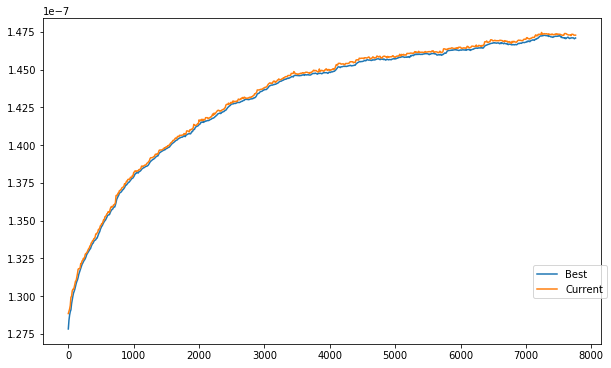

In [62]:
plot_SA(s2, s3, 10)

# Improving the route by moving prime cities

We start from the route with length 6 847 216.556585729

Reload route in case:

In [79]:
start_route = np.genfromtxt('files/route_after_clust_ordering.txt').astype(int)

In [80]:
edp(start_route, cities, not_primes_bool)

6847216.556585729

In [65]:
clusters = np.repeat(np.arange(1000), 200)[:len(cities)-1]
len(clusters)

197768

In [66]:
sorted_cities = cities[start_route[1:]]

In [67]:
kscities = np.concatenate((sorted_cities, clusters[:, np.newaxis]), 1)

In [68]:
n = len(np.unique(clusters))
n

989

In [69]:
subs = [0]*n

In [70]:
for i in range(n):
    subs[i] = kscities[kscities[:, 3] == i][:, :3]

In [71]:
lens = [len(subs[i]) for i in range(n)]
np.array(lens[-20:])

array([200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
       200, 200, 200, 200, 200, 200, 168])

We apply SA...

In [72]:
a = [0]*n
b = [0]*n
c = [0]*n

In [73]:
for i in range(n):
    a[i] = np.arange(len(subs[i]))

In [74]:
start_route_w0 = start_route[1:]
start_route_w0

array([ 42251,  12492, 151736, ..., 144501,  52086,  78934])

In [75]:
edp(start_route_w0, cities, not_primes_bool)

6847216.556585729

In [76]:
c_ids = [el[:,0] for el in subs]

After running the following...

In [77]:
from sa import SA, reverse_primes_mutation, swap_primes_mutation, edp_unordered_straight

In [78]:
np.random.seed(4)
start = datetime.now()
startl = datetime.now()
p = 0
last_dist = edp(start_route_w0, cities, not_primes_bool)
initial_dist = last_dist
print('Initial distance: {}'.format(last_dist))
for i in range(n):
    if (i % 100 == 0) and (i > 0):
        print('\nStart Loop {} at {}'.format(i, startl))
    
    perm_init = np.arange(len(subs[i]))
    a[i], b[i], c[i] = SA(subs[i], edp_unordered_straight, reverse_primes_mutation,
                          black_list = not_primes_bool, scale = 100000, n_to_mute= 10,
                          maxIter = np.inf,perm_init = perm_init, maxIterNoChange=1000)
    if ((i % (99 + p) == 0) or (i == n - 1)) and i > 0:
        p += 100
        endl = datetime.now()
        print('End loop {} at {}: {} seconds'.format(i, endl, (endl-startl).total_seconds()))
        startl = datetime.now()
    if i % 10 == 0:
        temp_routes = []
        for j in range(n):
            temp_routes.append(c_ids[j][a[j]])
        temp_full_route = np.concatenate(temp_routes).astype(int)
        temp_full_route = np.concatenate(([0], temp_full_route))
        temp_tot = edp(temp_full_route[1:], cities, not_primes_bool)
        print('\nLoop {}, Total distance so far: {}'.format(i, temp_tot))   
        if all(np.isin(temp_full_route, cities[:,0])) and all(np.isin(cities[:,0], temp_full_route)):
            print("Checked: the path goes through all cities")
        print('Improvement: {}'.format(temp_tot - last_dist))
        print('Total Improvement: {}'.format(temp_tot - initial_dist))
        last_dist = temp_tot        
end = datetime.now()
print('\nTotal time: {}'.format((end-start).total_seconds()))

Initial distance: 6847216.556585729

Loop 0, Total distance so far: 6846991.741012709
Checked: the path goes through all cities
Improvement: -224.81557301990688
Total Improvement: -224.81557301990688

Loop 10, Total distance so far: 6845743.75211204
Checked: the path goes through all cities
Improvement: -1247.988900668919
Total Improvement: -1472.804473688826

Loop 20, Total distance so far: 6844127.708496815
Checked: the path goes through all cities
Improvement: -1616.0436152257025
Total Improvement: -3088.8480889145285

Loop 30, Total distance so far: 6843488.9039969705
Checked: the path goes through all cities
Improvement: -638.8044998440892
Total Improvement: -3727.6525887586176

Loop 40, Total distance so far: 6842552.491430253
Checked: the path goes through all cities
Improvement: -936.4125667177141
Total Improvement: -4664.065155476332

Loop 50, Total distance so far: 6841350.400196226
Checked: the path goes through all cities
Improvement: -1202.0912340264767
Total Improvement: 


Loop 470, Total distance so far: 6794029.960401839
Checked: the path goes through all cities
Improvement: -1743.3195235654712
Total Improvement: -53186.59618389048

Loop 480, Total distance so far: 6792715.163157975
Checked: the path goes through all cities
Improvement: -1314.7972438633442
Total Improvement: -54501.39342775382

Loop 490, Total distance so far: 6791144.660573529
Checked: the path goes through all cities
Improvement: -1570.5025844462216
Total Improvement: -56071.89601220004
End loop 499 at 2019-07-04 14:11:34.977244: 202.914171 seconds

Start Loop 500 at 2019-07-04 14:11:34.977244

Loop 500, Total distance so far: 6790311.3751229625
Checked: the path goes through all cities
Improvement: -833.28545056656
Total Improvement: -56905.1814627666

Loop 510, Total distance so far: 6789573.686492283
Checked: the path goes through all cities
Improvement: -737.6886306796223
Total Improvement: -57642.870093446225

Loop 520, Total distance so far: 6788802.836660793
Checked: the path

KeyboardInterrupt: 

In [ ]:
c_ids = [el[:,0] for el in subs]
routes = []
for i in range(n):
    routes.append(c_ids[i][a[i]])

final_full_route = np.concatenate(routes).astype(int)
final_full_route = np.concatenate(([0], final_full_route))

In [ ]:
np.savetxt('files/final_after_sa.txt', final_full_route)

We have obtained the following route:

In [ ]:
final_full_route = np.genfromtxt('files/final_after_sa.txt').astype(int)

In [ ]:
final_full_route

In [ ]:
edp(final_full_route, cities, not_primes_bool)

The length of the final route is 6 794 694.175852176